In [1]:
import pandas as pd
import numpy as np
import re
from io import StringIO
from sklearn.linear_model import LinearRegression as LinReg
from missing_values import *

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

/home/abyzs/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Let's do some data preparation. Change '-' before ',' to zero-string as provide correct parsing NaN values. 
Delete index column, as pandas have it's own

In [2]:
def read():
    with open('heroes_information.csv', 'r') as file:
        f = file.read()
    f = re.sub(r'\-\,', ',', f)
    f = f.lower()
    heroes = pd.read_csv(StringIO(f))
    heroes.drop(columns=['Unnamed: 0'], inplace=True)
    return heroes
heroes = read()

In [3]:
heroes.head()

,name,gender,eye color,race,hair color,height,publisher,skin color,alignment,weight
0,a-bomb,male,yellow,human,no hair,203.0,marvel comics,NaN,good,441.0
1,abe sapien,male,blue,icthyo sapien,no hair,191.0,dark horse comics,blue,good,65.0
2,abin sur,male,blue,ungaran,no hair,185.0,dc comics,red,good,90.0
3,abomination,male,green,human / radiation,no hair,203.0,marvel comics,NaN,bad,441.0
4,abraxas,male,blue,cosmic entity,black,-99.0,marvel comics,NaN,bad,-99.0


In [4]:
heroes.dtypes

name           object
gender         object
eye color      object
race           object
hair color     object
height        float64
publisher      object
skin color     object
alignment      object
weight        float64
dtype: object

In [5]:
heroes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 10 columns):
name          734 non-null object
gender        705 non-null object
eye color     562 non-null object
race          430 non-null object
hair color    562 non-null object
height        734 non-null float64
publisher     719 non-null object
skin color    72 non-null object
alignment     727 non-null object
weight        732 non-null float64
dtypes: float64(2), object(8)
memory usage: 57.4+ KB


Persentage of missing values per column

In [6]:
for col in heroes.columns:
    print(f'{pd.isna(heroes[col]).sum()/len(heroes) * 100:.2f}%\t{col}')

0.00%	name
3.95%	gender
23.43%	eye color
41.42%	race
23.43%	hair color
0.00%	height
2.04%	publisher
90.19%	skin color
0.95%	alignment
0.27%	weight


NaN values visualizing. Yellow - NaN. Vertical axis - columns, gorizontal - samples. Divided to 4 plots just to let see in one screen

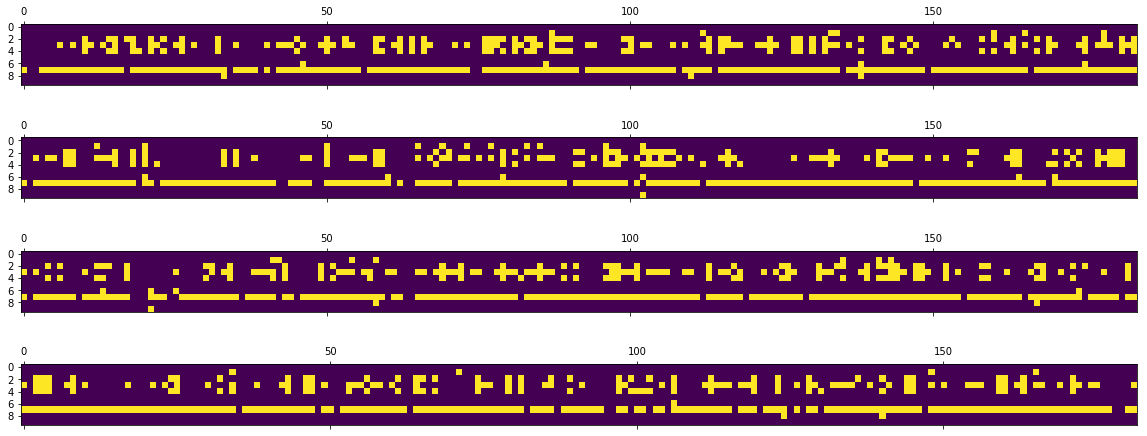

In [7]:
plot_nan(heroes)

Unique amount in each column

In [8]:
for col in heroes.columns:
    print(col, len(heroes[col].unique()))

name 715
gender 3
eye color 23
race 62
hair color 28
height 54
publisher 25
skin color 17
alignment 4
weight 136


research of weights in each feature

In [9]:
n = len(heroes)
for col in heroes.columns:
    if len(heroes[col].unique()) > 30:
        continue
    print(col)
    l = []
    for name in heroes[col].unique():
        if str(name) == 'nan':
            l.append((sum(pd.isna(heroes[col])) / n * 100, 'NaN'))
#             print(f'\t{sum(pd.isna(heroes[col])) / n * 100:.2f}%\t{name}')
        else:
            l.append((len(heroes[(heroes[col] == name)]) / n * 100, str(name)))
#             print(f'\t{len(heroes[(heroes[col] == name)]) / n * 100:.2f}%\t{name}')
    else:
        l.sort(key=lambda x: x[0], reverse=True)
        for i in l:
            print(f'\t{i[0]:.2f}%\t{i[1]}')

gender
	68.80%	male
	27.25%	female
	3.95%	NaN
eye color
	30.65%	blue
	23.43%	NaN
	17.17%	brown
	9.95%	green
	6.27%	red
	3.13%	black
	2.59%	yellow
	2.32%	white
	0.82%	grey
	0.82%	hazel
	0.54%	purple
	0.41%	gold
	0.27%	violet
	0.27%	yellow (without irises)
	0.27%	amber
	0.14%	silver
	0.14%	yellow / red
	0.14%	blue / white
	0.14%	green / blue
	0.14%	white / red
	0.14%	indigo
	0.14%	yellow / blue
	0.14%	bown
hair color
	23.43%	NaN
	21.93%	black
	13.90%	blond
	11.72%	brown
	10.22%	no hair
	6.95%	red
	3.13%	white
	1.77%	auburn
	1.09%	green
	0.95%	strawberry blond
	0.68%	purple
	0.68%	grey
	0.54%	brown / white
	0.54%	silver
	0.41%	blue
	0.27%	orange
	0.27%	yellow
	0.14%	pink
	0.14%	magenta
	0.14%	brown / black
	0.14%	red / grey
	0.14%	orange / white
	0.14%	brownn
	0.14%	gold
	0.14%	red / orange
	0.14%	indigo
	0.14%	red / white
	0.14%	black / blue
publisher
	52.86%	marvel comics
	29.29%	dc comics
	2.59%	nbc - heroes
	2.45%	dark horse comics
	2.04%	NaN
	1.91%	image comics
	1.91%	george lucas
	0

Change NaN values. As most of columns are text-like, use 'most common' as knn mode.

In [10]:
knn(heroes, 'weight', v_columns=['gender', 'eye color', 'race', 'hair color', 'height',
       'publisher', 'skin color'], mode='mean')

knn(heroes, 'publisher', v_columns=['gender', 'race', 'eye color', 'height',
       'hair color', 'skin color', 'weight'], mode='mod')

knn(heroes, 'gender', v_columns=['race', 'hair color', 'height',
       'publisher', 'eye color', 'skin color', 'weight'], mode='mod')


knn(heroes, 'eye color', v_columns=['gender', 'race', 'hair color', 'height',
       'publisher', 'skin color', 'weight'], mode='mod')

knn(heroes, 'hair color', v_columns=['gender', 'race', 'eye color', 'height',
       'publisher', 'skin color', 'weight'], mode='mod')

heroes = drop(heroes, ['race', 'skin color'], axis=1)
heroes = replace(heroes, ['alignment'], mode='unknown')



Look if there are any NaN values?

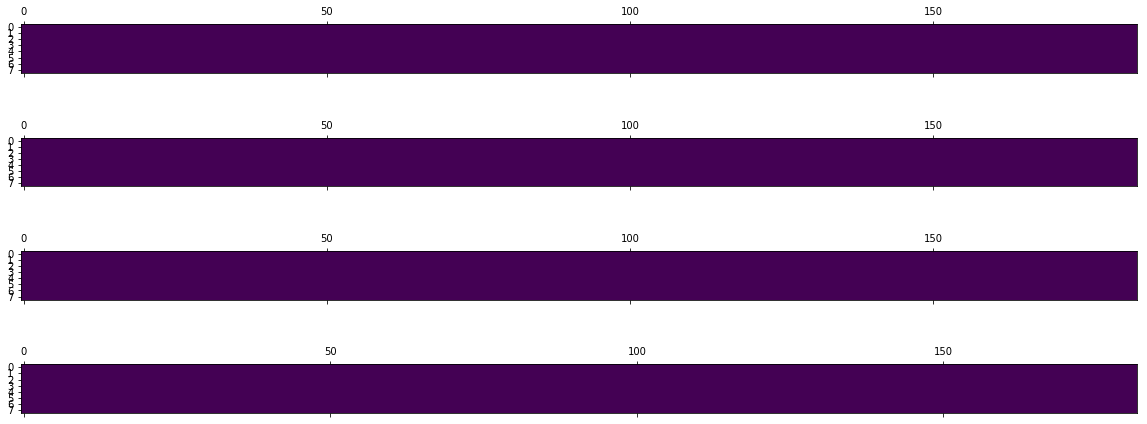

In [11]:
plot_nan(heroes)

In [12]:
for col in heroes.columns:
    print(f'{pd.isna(heroes[col]).sum()/len(heroes) * 100:.2f}%\t{col}')

0.00%	name
0.00%	gender
0.00%	eye color
0.00%	hair color
0.00%	height
0.00%	publisher
0.00%	alignment
0.00%	weight


Creating 2 models one with class_weight, second - without it

In [13]:
def ml(heroes):
    models = [
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight = {
            'good' : 0.67,
            'bad' : 0.28,
            'neutral' : 0.3,
            'unknown' : 0.1
        }),
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    ]

    columns = list(heroes.columns)
    columns.remove('alignment')
    columns.remove('name')
    print(columns)
    dtr = heroes.loc[ : , columns]
    dtr = np.array(pd.get_dummies(dtr, columns=['gender', 'eye color', 'hair color', 'publisher']))
    dte = np.array(heroes.loc[ : , 'alignment'])

    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    for m in models:
        acc = []
        conf = []
        for trn_idx, val_idx in folds.split(heroes):
            reg = m
            reg.fit(dtr[trn_idx, :], dte[trn_idx])
            q = reg.predict(dtr[val_idx, :])
    #         print(q)
    #         for i in range(len(q)):
    #             print(q[i], heroes.iloc[val_idx,0].iloc[i])
            acc.append(accuracy_score(dte[val_idx], q) ** 0.5)
            conf.append(confusion_matrix(dte[val_idx], q))
        print(f'accuracy : {sum(acc)/len(acc) * 100:.1f}%')
        print(f'mean confusing matrix :\n{sum(conf) / 5}')

In [14]:
ml(heroes)

['gender', 'eye color', 'hair color', 'height', 'publisher', 'weight']
accuracy : 81.8%
mean confusing matrix :
[[13.8 27.2  0.4  0. ]
 [14.4 84.4  0.2  0.2]
 [ 1.4  3.4  0.   0. ]
 [ 0.6  0.8  0.   0. ]]
accuracy : 81.5%
mean confusing matrix :
[[13.2 27.6  0.6  0. ]
 [14.4 84.2  0.4  0.2]
 [ 1.4  3.2  0.2  0. ]
 [ 0.6  0.8  0.   0. ]]


Ouch, looks like we have no tolerance. Thats why we replace missing data, according to 'race' and 'skin color'.
But as we are European we need to be more tolerant! So, let's remove 'race' and 'skin color' before replacing missing data.

In [15]:
heroes = read()
heroes = drop(heroes, ['race', 'skin color'], axis=1)
heroes = replace(heroes, ['alignment'], mode='unknown')

knn(heroes, 'weight', v_columns=['gender', 'eye color', 'hair color', 'height',
       'publisher'], mode='mean')

knn(heroes, 'publisher', v_columns=['gender', 'eye color', 'height',
       'hair color', 'weight'], mode='mod')

knn(heroes, 'gender', v_columns=['hair color', 'height',
       'publisher', 'eye color', 'weight'], mode='mod')


knn(heroes, 'eye color', v_columns=['gender', 'hair color', 'height',
       'publisher',  'weight'], mode='mod')

knn(heroes, 'hair color', v_columns=['gender', 'eye color', 'height',
       'publisher', 'weight'], mode='mod')


ml(heroes)

['gender', 'eye color', 'hair color', 'height', 'publisher', 'weight']
accuracy : 82.2%
mean confusing matrix :
[[13.  28.   0.4  0. ]
 [12.8 85.8  0.4  0.2]
 [ 1.8  2.6  0.4  0. ]
 [ 0.6  0.8  0.   0. ]]
accuracy : 81.2%
mean confusing matrix :
[[12.4 28.6  0.4  0. ]
 [14.4 84.2  0.4  0.2]
 [ 1.8  2.8  0.2  0. ]
 [ 0.6  0.8  0.   0. ]]


And what can we see? The accuracy score is growing up. Isn't that a miracle? Just a bit of tolerance give us 0.4% of score. Don't forget, it can be the decisive factor in your future projects!